In [6]:
import numpy as np
import pandas as pd
import datahugger
import h5py

In [7]:
dh = datahugger.get("10.17605/OSF.IO/EWS27", "../data")
dh.tree() # Remains to be done: extracting the paths instead of hardcoded (as below):

File already exists: 19_09_2023_22_58_21/LMAHeureuxPorosityDiff.hdf5
File already exists: 19_09_2023_22_58_21/U_at_bottom.h5
data/
└── 19_09_2023_22_58_21/
    ├── LMAHeureuxPorosityDiff.hdf5
    └── U_at_bottom.h5

1 directories, 2 files
README Data Code


Importing U_at_bottom.h5 using h5py results in an odd file structure so for now using pandas instead.

In [26]:
U_path = "../data/19_09_2023_22_58_21/U_at_bottom.h5"
U_file = pd.read_hdf(U_path)
U_at_bottom_and_times = U_file.to_numpy()
U_at_bottom_and_times.shape

(3001, 2)

In [27]:
Solution_path = '../data/19_09_2023_22_58_21/LMAHeureuxPorosityDiff.hdf5' # Also to be downloaded
Solution = h5py.File(Solution_path, 'r')
data = Solution['data']
data.shape

(3001, 5, 200)

Check the values of U at the bottom:

In [28]:
U_at_bottom_and_times[2995:3000, 1]

array([0.09411153, 0.09411154, 0.09411154, 0.09411155, 0.09411155])

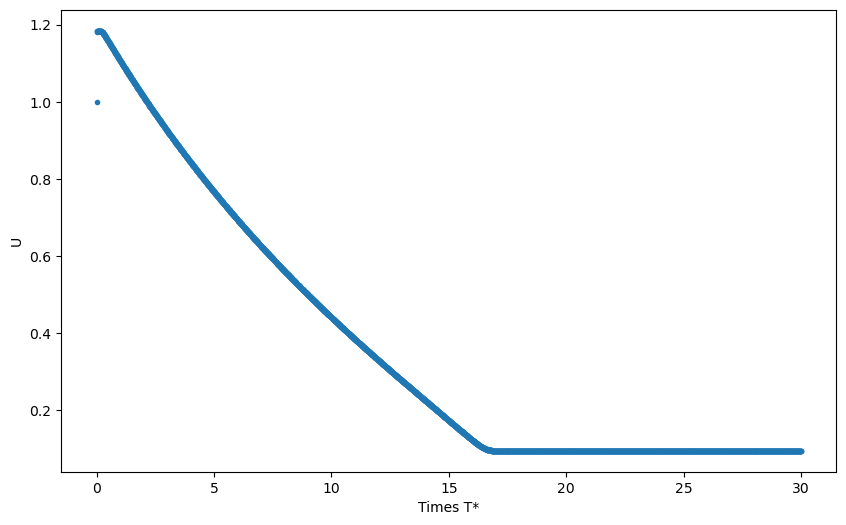

In [29]:
import pylab as pyl
pyl.figure(figsize=(10,6))
pyl.plot(U_at_bottom_and_times[:, 0], U_at_bottom_and_times[:, 1], ".")
pyl.xlabel("Times T*")
pyl.ylabel("U")
pyl.show()

### What is it supposed to be according to Eq. 46.
The formula for K as below is used for moderate (0.05, 0.95) values of phi in Fortran and throughout in Python. So it might need changing for phi at the bottom for the calculation of U.

In [30]:
def k_normal(phi):
    k = betasV * phi ** 3 / (1 - phi) ** 2
    k = k * (1 - np.exp(-10 * (1 - phi) / phi))
    return k

Keeping the same convention as in Fortran for easy comparing, at the expense of creating redundant variables:

In [31]:
S = float(Solution.attrs['sedimentationrate'])
Vscale = S 
beta = float(Solution.attrs['beta']) # cm/a
P_32 = beta/Vscale
betasV = P_32

In [32]:
phi0 = float(Solution.attrs['Phi0'])
rhow = float(Solution.attrs['rhow'])
rhoa = float(Solution.attrs['rhoa'])
CA0 = float(Solution.attrs['CA0'])
rhoc = float(Solution.attrs['rhoc'])
CC0 = float(Solution.attrs['CC0'])
rhot = float(Solution.attrs['rhot'])
rhos0 = rhoa * CA0 + rhoc * CC0 + rhot * (1 - (CA0 + CC0))
rhos0

2.8630000000000004

In [33]:
phi_bottom = data[3000,4,199]
CA = data[3000,0,199]
CC = data[3000,1,199]
rhos_bottom = rhoa * CA + rhoc * CC + rhot * (1 - (CA + CC))

In [34]:
U = 1 - k_normal(phi0)/S * (1 - phi0) * (rhos0/rhow - 1) + k_normal(phi_bottom)/S * (1 - phi_bottom) * (rhos_bottom/rhow - 1)

U from Eq. 46 is:

In [35]:
U

-8.763146627725334

Whereas U saved from the solution is:

In [37]:
U_at_bottom_and_times[3000, 1]

0.09411155465117016

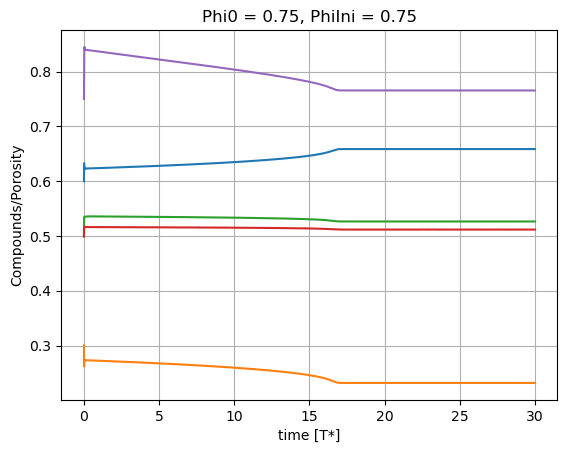

In [36]:
import matplotlib.pyplot as plt
t = np.array(Solution['times'][:])
s = np.array(data[:,:,0])
fig, ax = plt.subplots()
ax.plot(t, s)
ax.set(xlabel='time [T*]', ylabel='Compounds/Porosity',
       title=f"Phi0 = {phi0}, PhiIni = {Solution.attrs['PhiIni']}")
ax.grid()